In [27]:
# install tensor flow
!pip install tensorflow

In [28]:
# install version 3.5.2 to enable subplots 
!pip install matplotlib==3.5.2 --user

In [29]:
print(matplotlib.__version__)

3.5.2


In [30]:
# install version 3.5.2 to enable subplots 
!pip install librosa==0.9.1

In [31]:
# check if matplotlib downgraded to 3.5 to enable subplots
print(librosa.__version__)

0.9.1


In [32]:
# import modules needed
import sys  
from warnings import simplefilter # import warnings filter
from tensorflow.python.client import device_lib # check for GPU availability

# imports 
import tensorflow
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from matplotlib import pyplot
import matplotlib.pyplot
from keras.models import load_model
import numpy as np
from tqdm import tqdm

#import modules for file names
import glob

# import modules needed for audio processing
import librosa
import librosa.display
import IPython.display as ipd

# imports for feature transformation
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from tensorflow.keras.utils import to_categorical


simplefilter(action='ignore', category=FutureWarning) # ignore all future warnings
print("User Current Version:-", sys.version)
print(device_lib.list_local_devices())

User Current Version:- 3.10.9 (main, Mar  1 2023, 12:20:14) [Clang 14.0.6 ]
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11994611246484458493
xla_global_id: -1
]


In [33]:
# Dataset details
# 264 recordings from 88 species
# using pandas read the 

birdsong = pd.read_csv('dataset/birdsong_metadata.csv')
birdsong = birdsong[["file_id", "english_cname"]] # only select 2 columns
# display the dataframe with columns extracted from the .csv 
birdsong


,file_id,english_cname
0,132608,Common Redpoll
1,132611,Common Redpoll
2,35068,Common Redpoll
3,82715,Marsh Warbler
4,64685,Marsh Warbler
...,...,...
259,132392,Song Thrush
260,146756,Song Thrush
261,27060,Northern Lapwing
262,97982,Northern Lapwing


In [34]:
# add the csv data to a dictionary, get the file_id as "keys" and the "english_cname" or the bird name as it's values
bird = birdsong.to_dict()
ids=list(bird['file_id'].values())
print('Number of instances: ',len(ids))
bird_name =list(bird['english_cname'].values())

Number of instances:  264


In [35]:
# slicing the wave files into smaller clips of 5seconds 
# all .flac bird sound files are located at working directory under dataset/recordings/*
dataset=[]
for filename in glob.iglob('dataset/recordings/*'):
    if (filename[-5:]=='.flac'):
        identity = filename.split('\\')[0][:-5]
        # Strip the first 21 characters
        identity = filename[21:]
        # Strip the last 5 characters
        identity = identity[:-5]
        index=ids.index(int(identity))
        label = bird_name[index]
        duration = librosa.get_duration(filename=filename)
        if duration>= 5: 
            slice_size = 5 #slice the first 5 seconds off
            iterations = int((duration-slice_size)/(slice_size - 1))
            iterations += 1
            # initial_offset is the starting point of the recording
            initial_offset = (duration - ((iterations*(slice_size-1)) + 1))/2 
            for i in range(iterations):
                # starting point of the slice from the initial_offset of the recording
                offset = initial_offset + i*(slice_size-1)
                dataset.append({"filename": filename, "label": label, "offset": offset})
dataset = pd.DataFrame(dataset)
dataset.info()  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4231 entries, 0 to 4230
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   filename  4231 non-null   object 
 1   label     4231 non-null   object 
 2   offset    4231 non-null   float64
dtypes: float64(1), object(2)
memory usage: 99.3+ KB


In [36]:
# the sliced recordings offset values for each bird type as label, 
# offset values and correspoding filename displayed
dataset = dataset[dataset['label'].isin(list(dataset.label.value_counts()[:10].index))]
dataset.head(20)

,filename,label,offset
122,dataset/recordings/xc146260.flac,Garden Warbler,0.770091
123,dataset/recordings/xc146260.flac,Garden Warbler,4.770091
124,dataset/recordings/xc146260.flac,Garden Warbler,8.770091
125,dataset/recordings/xc146260.flac,Garden Warbler,12.770091
126,dataset/recordings/xc146260.flac,Garden Warbler,16.770091
127,dataset/recordings/xc146260.flac,Garden Warbler,20.770091
128,dataset/recordings/xc146260.flac,Garden Warbler,24.770091
129,dataset/recordings/xc146260.flac,Garden Warbler,28.770091
130,dataset/recordings/xc146260.flac,Garden Warbler,32.770091
131,dataset/recordings/xc146260.flac,Garden Warbler,36.770091


In [37]:
# display the number of recording samples from the dataset per bird type
dataset.label.value_counts()

Corn Bunting          186
Eurasian Skylark      143
Common Nightingale    140
Barn Swallow          131
Sedge Warbler         125
Common Linnet         124
Garden Warbler        104
Eurasian Wryneck       93
Common Starling        92
Common Chaffinch       89
Name: label, dtype: int64

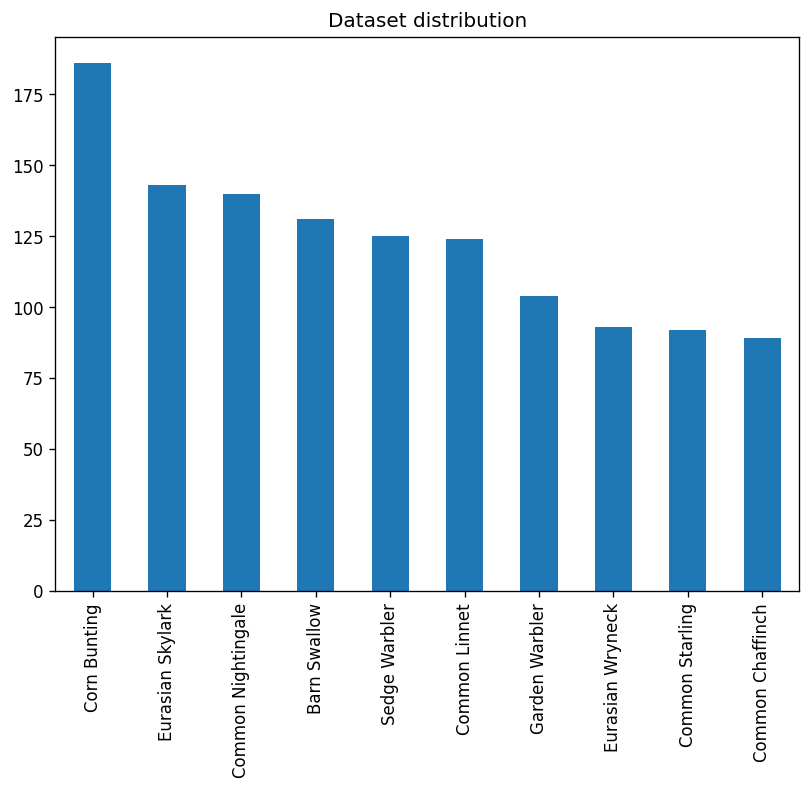

In [38]:
# display the graph with the dataset distribution
# show the bird names on the x-axis and the number of recordings per bird on the y-axis
pyplot.figure(figsize=(8,6), dpi=120)
dataset.label.value_counts().plot(kind='bar', title="Dataset distribution")
plt.show() 

In [39]:

# Split the data into training and test samples, 80% for training and 20% for testing
train, test = train_test_split(dataset, test_size=0.2, random_state=123)
print("Train: %i" % len(train))
print("Test: %i" % len(test))

Train: 981
Test: 246


dataset/recordings/xc146260.flac
dataset/recordings/xc102060.flac
dataset/recordings/xc120664.flac
dataset/recordings/xc157322.flac
dataset/recordings/xc123167.flac
dataset/recordings/xc123170.flac
dataset/recordings/xc123808.flac
dataset/recordings/xc42698.flac
dataset/recordings/xc133054.flac
dataset/recordings/xc42803.flac


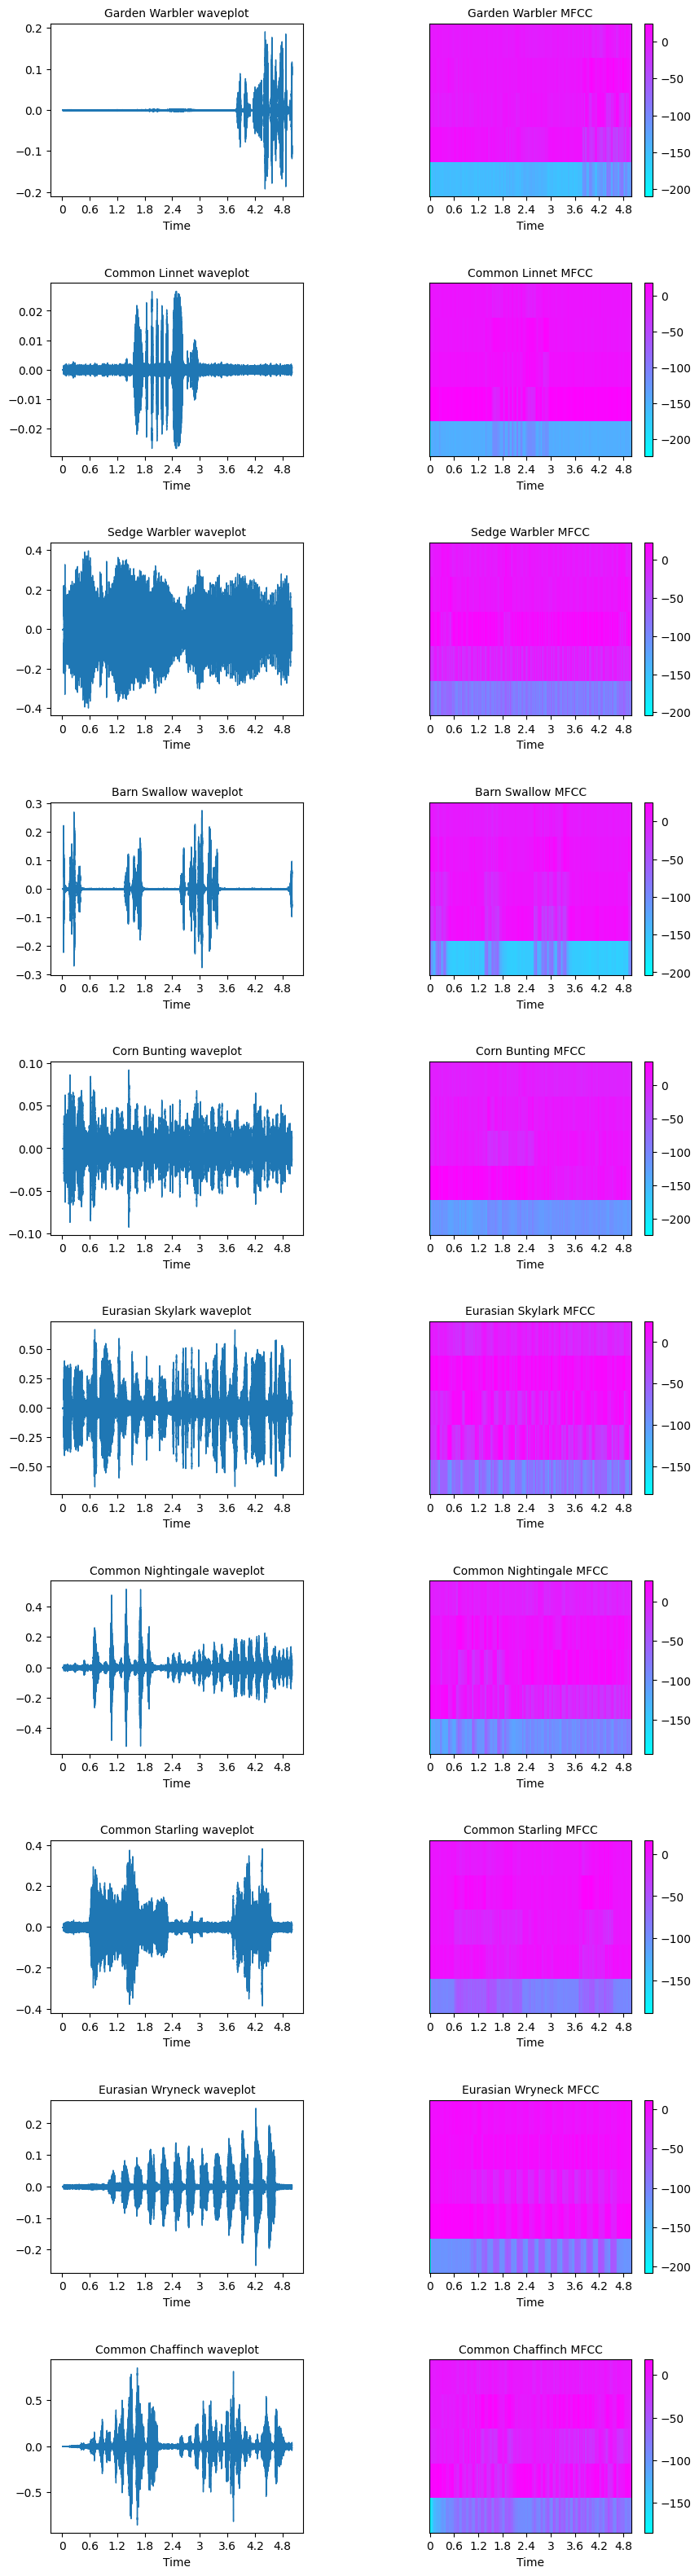

In [40]:

# display the waveplots and the MFCC respectively for each of the 10 bird types
plt.figure(figsize=(10,40))
idx = 0
for label in dataset.label.unique():    
    y, sr = librosa.load(dataset[dataset.label==label].filename.iloc[1], duration=5)
    print(dataset[dataset.label==label].filename.iloc[1])
    
    # Wave plot
    idx+=1
    plt.subplot(10, 2, idx)
    plt.title("%s waveplot" % label,fontsize=10)
    librosa.display.waveshow(y, sr=sr)

    # MFCC 
    idx+=1
    mfccs = librosa.feature.mfcc(y,n_fft=255,hop_length=512,n_mfcc=13,n_mels=5)
    plt.subplot(10, 2, idx)
    librosa.display.specshow(mfccs,sr=sr,cmap='cool',hop_length=512, x_axis='time')
    plt.title("%s MFCC" % label,fontsize=10)
    plt.colorbar()

plt.subplots_adjust(hspace=0.5, wspace=0.5)
plt.show()

In [41]:
# Extract mfcc features for each of the processed audio recordings
def extract_features(audio_path,offset):
    y, sr = librosa.load(audio_path, offset=offset, duration=5)
    # function is used to compute the MFCC's using librosa
    mfccs = librosa.feature.mfcc(y,n_fft=255,
                                 hop_length=512,
                                 n_mfcc=13,
                                 n_mels=5)
    return mfccs

In [42]:
x_train = []
x_test = []

# append the extracted features extracted for each recording from the "train" and "test" datasets
# into testing and training arrays

for idx in tqdm(range(len(train))):
    x_train.append(extract_features(train.filename.iloc[idx],train.offset.iloc[idx]))

for idx in tqdm(range(len(test))):
    x_test.append(extract_features(test.filename.iloc[idx],test.offset.iloc[idx]))
    
x_test = (np.asarray(x_test))
x_train = (np.asarray(x_train))

print("X train:", train.shape)
print("X test:", test.shape)

100%|█████████████████████████████████████████| 246/246 [00:16<00:00, 14.87it/s]

X train: (981, 3)
X test: (246, 3)


In [43]:
# Encode Labels
encoder = LabelEncoder()
encoder.fit(train.label)

y_train = encoder.transform(train.label)
y_test = encoder.transform(test.label)

# Compute class weights
class_weights = class_weight.compute_class_weight(class_weight='balanced',classes = np.unique(y_train),y= y_train)

In [44]:
# x and y train and test shapes before reshaping
print("X train shape:", x_train.shape)
print("Y train shape:", y_train.shape)

print("X test shape:", x_test.shape)
print("Y train shape:", y_test.shape)

X train shape: (981, 5, 216)
Y train shape: (981,)
X test shape: (246, 5, 216)
Y train shape: (246,)


In [45]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2])
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2])
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# x and y train and test shapes after reshaping
print("X train:", x_train.shape)
print("Y train:", y_train.shape)
print("X test:", x_test.shape)
print("Y test:", y_test.shape)

X train: (981, 5, 216)
Y train: (981, 10)
X test: (246, 5, 216)
Y test: (246, 10)


In [46]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from tensorflow.keras import regularizers

model = Sequential([
    LSTM(64, return_sequences=False, input_shape=(5,216),kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(10, activation='softmax')
])

# PROVIDES MODEL SUMMARY
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                71936     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 128)               8320      
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 10)                1290      
                                                                 
Total params: 81546 (318.54 KB)
Trainable params: 81546 (318.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [47]:
# using adam optimizer with learning rate(lr) 10^-3
adam = tensorflow.keras.optimizers.Adam(learning_rate=0.001)
# compile model using categorical crossentropy, adam optimizer with lr 10^-3 and metrics for measuring results as "accuray"
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [48]:
# Train the model in 32 batches and for 100 epochs 
from datetime import datetime 
start = datetime.now()
history = model.fit(x_train, y_train,
              batch_size=32,
              epochs=100,
              validation_data=(x_test, y_test),
              shuffle=True)

duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/100
31/31 [==============================] - 1s 8ms/step - loss: 4.4244 - accuracy: 0.1386 - val_loss: 4.0546 - val_accuracy: 0.2276
Epoch 2/100
31/31 [==============================] - 0s 3ms/step - loss: 3.8428 - accuracy: 0.2691 - val_loss: 3.6123 - val_accuracy: 0.2846
Epoch 3/100
31/31 [==============================] - 0s 3ms/step - loss: 3.3817 - accuracy: 0.3660 - val_loss: 3.3066 - val_accuracy: 0.3049
Epoch 4/100
31/31 [==============================] - 0s 3ms/step - loss: 2.9970 - accuracy: 0.4373 - val_loss: 3.0538 - val_accuracy: 0.3415
Epoch 5/100
31/31 [==============================] - 0s 3ms/step - loss: 2.6413 - accuracy: 0.5240 - val_loss: 2.8523 - val_accuracy: 0.3374
Epoch 6/100
31/31 [==============================] - 0s 3ms/step - loss: 2.2789 - accuracy: 0.6279 - val_loss: 2.6785 - val_accuracy: 0.3496
Epoch 7/100
31/31 [==============================] - 0s 3ms/step - loss: 1.9351 - accuracy: 0.7176 - val_loss: 2.5736 - val_accuracy: 0.3740
Epoch 8/100
3

Epoch 59/100
31/31 [==============================] - 0s 3ms/step - loss: 0.4849 - accuracy: 0.9470 - val_loss: 2.6927 - val_accuracy: 0.4472
Epoch 60/100
31/31 [==============================] - 0s 3ms/step - loss: 0.4828 - accuracy: 0.9562 - val_loss: 2.7859 - val_accuracy: 0.4390
Epoch 61/100
31/31 [==============================] - 0s 3ms/step - loss: 0.4560 - accuracy: 0.9592 - val_loss: 2.7202 - val_accuracy: 0.4350
Epoch 62/100
31/31 [==============================] - 0s 3ms/step - loss: 0.4468 - accuracy: 0.9684 - val_loss: 2.7759 - val_accuracy: 0.4797
Epoch 63/100
31/31 [==============================] - 0s 3ms/step - loss: 0.4094 - accuracy: 0.9817 - val_loss: 2.9055 - val_accuracy: 0.4512
Epoch 64/100
31/31 [==============================] - 0s 3ms/step - loss: 0.4094 - accuracy: 0.9735 - val_loss: 2.9144 - val_accuracy: 0.4309
Epoch 65/100
31/31 [==============================] - 0s 3ms/step - loss: 0.4057 - accuracy: 0.9725 - val_loss: 2.9098 - val_accuracy: 0.4431
Epoch 

Text(0.5, 1.0, 'Accuracy Curves')

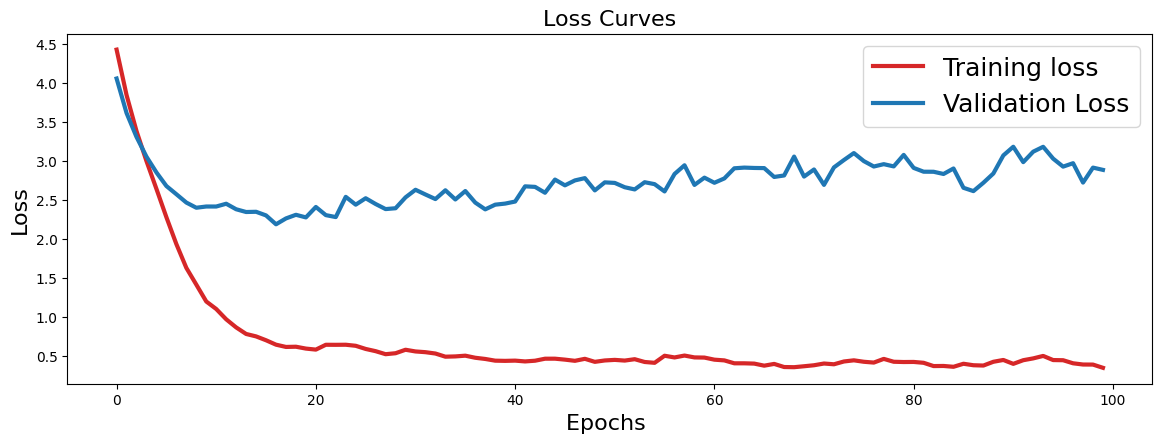

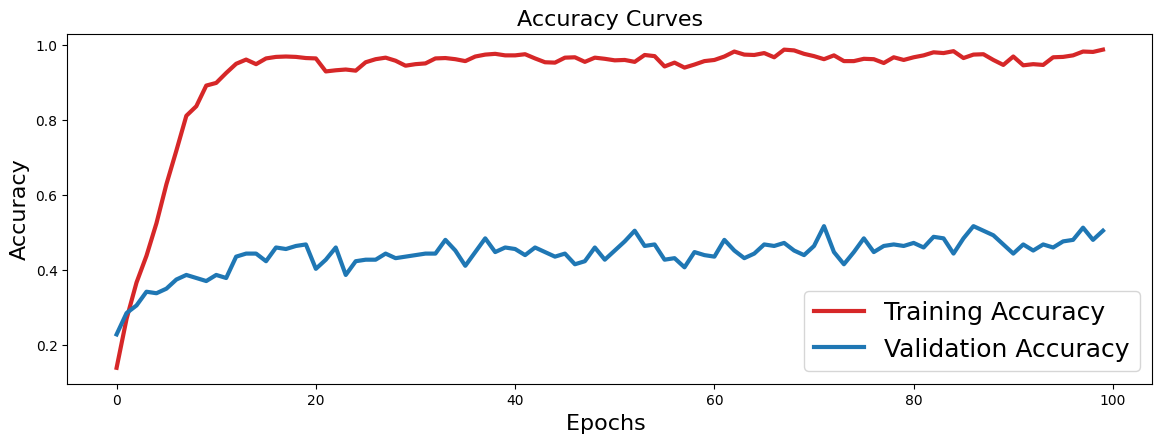

In [49]:
# Loss Curves
plt.figure(figsize=[14,10])
plt.subplot(211)
plt.plot(history.history['loss'],'#d62728',linewidth=3.0)
plt.plot(history.history['val_loss'],'#1f77b4',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
# Accuracy Curves
plt.figure(figsize=[14,10])
plt.subplot(212)
plt.plot(history.history['accuracy'],'#d62728',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'#1f77b4',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [50]:
# get accuracy score for the model 
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

8/8 [==============================] - 0s 1ms/step - loss: 2.8852 - accuracy: 0.5041
Test loss: 2.8852334022521973
Test accuracy: 0.5040650367736816


In [51]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

In [52]:
# Display precision,f1 score,recall scores

predictions = model.predict(x_test, verbose=1)

y_true, y_pred = [],[]
classes = encoder.classes_
for idx, prediction in enumerate(predictions): 
    y_true.append(classes[np.argmax(y_test[idx])])
    y_pred.append(classes[np.argmax(prediction)])
    
print(classification_report(y_pred, y_true))

8/8 [==============================] - 0s 1ms/step
                    precision    recall  f1-score   support

      Barn Swallow       0.63      0.49      0.55        35
  Common Chaffinch       0.19      0.17      0.18        23
     Common Linnet       0.52      0.64      0.57        22
Common Nightingale       0.40      0.29      0.33        42
   Common Starling       0.64      0.88      0.74         8
      Corn Bunting       0.42      0.50      0.46        36
  Eurasian Skylark       0.27      0.50      0.35        14
  Eurasian Wryneck       1.00      0.76      0.86        29
    Garden Warbler       0.38      0.50      0.43        10
     Sedge Warbler       0.69      0.67      0.68        27

          accuracy                           0.50       246
         macro avg       0.51      0.54      0.52       246
      weighted avg       0.53      0.50      0.51       246



In [53]:
classes

array(['Barn Swallow', 'Common Chaffinch', 'Common Linnet',
       'Common Nightingale', 'Common Starling', 'Corn Bunting',
       'Eurasian Skylark', 'Eurasian Wryneck', 'Garden Warbler',
       'Sedge Warbler'], dtype=object)

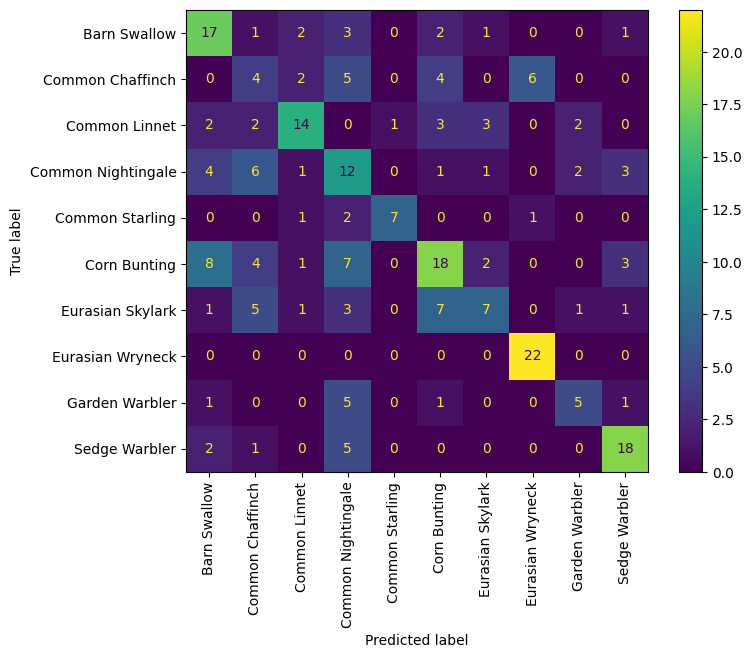

In [54]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(y_true, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels=classes)
fig, ax = plt.subplots(figsize=(8, 6))
cm_display.plot(ax=ax)
# Rotate the x-axis labels to make them vertical
plt.xticks(rotation=90)
plt.show()

In [55]:
model_name = "birdSoundClassifier.h5"
model.save(model_name)

/Users/srijachatterjee/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [56]:
# load model
from keras.models import load_model
model = load_model("birdSoundClassifier.h5")

In [57]:
# load and evaluate a saved model
# File path for the recording we want to be classy

classify_file = "dataset/recordings/xc123168.flac"
x_test = []
x_test.append(extract_features(classify_file,0.5))
x_test = np.asarray(x_test)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
pred = model.predict(x_test,verbose=1)
print(pred)

1/1 [==============================] - 0s 114ms/step
[[1.0242463e-03 5.0828145e-05 3.4521120e-03 5.8864309e-05 7.1209317e-05
  9.9493909e-01 1.2684763e-04 3.0174228e-06 2.9778141e-05 2.4399671e-04]]


In [58]:
# predict a sample using the trained model
pred_class = model.predict(x_test)
index = np.argmax(pred_class, axis=1)
print(classes[index])

1/1 [==============================] - 0s 15ms/step
['Corn Bunting']


In [59]:
# verify the bird name using it's file_id
actual = birdsong.loc[birdsong['file_id'] == 123168]
actual

,file_id,english_cname
84,123168,Corn Bunting
